In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Features relevant to predicting price of a listing

In [2]:
columns = ["Country", "City", "State", "Neighbourhood Cleansed", 
"Host Since", "Host Response Time", "Host Response Rate", "Calculated host listings count",
"Property Type", "Room Type", "Accommodates", "Bedrooms", "Beds", "Bed Type",  "Square Feet", "Cancellation Policy",
"Minimum Nights", "Maximum Nights", "Has Availability", "Availability 30", "Availability 60", "Availability 90", "Availability 365",
"Number of Reviews", "Reviews per Month", "First Review", "Last Review", "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness","Review Scores Checkin", "Review Scores Communication", "Review Scores Location","Review Scores Value",
"Features",
"Amenities",
"Price"]

# "Neighbourhood Group Cleansed",
# "Square Feet": 97.56% of entries have NULL values => cannot be used
# "Calendar Updated"
# "Weekly Price", "Monthly Price", "Security Deposit", "Cleaning Fee", "Guests Included", "Extra People",

features_new_host = ["Country", "City", "Neighbourhood Cleansed",
                   "Property Type", "Room Type", "Accommodates","Bedrooms", "Beds", "Bed Type", "Cancellation Policy",
                   "Minimum Nights",
                   "Price"]

features_existing_host = ["Country", "City", "Neighbourhood Cleansed",
                          "Property Type", "Room Type", "Accommodates", "Bedrooms", "Beds", "Bed Type", "Cancellation Policy",
                          "Minimum Nights", "Availability 30", "Availability 60", "Availability 90", "Availability 365",
                          "Number of Reviews", "Reviews per Month", "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness","Review Scores Checkin", "Review Scores Communication", "Review Scores Location","Review Scores Value",
                          "Host Since", "Host Response Time", "Host Response Rate", "Calculated host listings count",
                          "Price"]

############################################
########## Feature pre-processing ##########
#### Numerical (Input text fields)
# "Minimum Nights", "Availability 30", "Availability 60", "Availability 90", "Availability 365"
# "Number of Reviews", 
# Review Scores Rating(20-100)
# "Host Since" (num_days = current_date - host_since_date), Host Response Rate(0-100), "Calculated host listings count"
# Price (Convert from local currency to USD)

#### Numerical (Dropdown numerical values)
# Accommodates(1-16), "Bedrooms"(0-10), "Beds"(0-16)
# "Review Scores Accuracy(2-10)", "Review Scores Cleanliness(2-10)","Review Scores Checkin(2-10)", "Review Scores Communication(2-10)", "Review Scores Location(2-10)","Review Scores Value(2-10)"

#### Label encoding (0, 1, 2 .... n_categories-1) (Category dropdowns -> on user select must be assigned numerical value)
# "Country", "City", "Neighbourhood Cleansed"
# "Property Type", "Room Type", "Bed Type", "Cancellation Policy"
# "Host Response Time"
############################################


# TODO
# Host since -> convert to days ----------------------------------- Done
# Features -> Extract features  ----------------------------------- Done
# Amenities -> Extract features ----------------------------------- Done
# Price -> Convert to local currency
# Verify missing features (Listing type etc...) ------------------- Done
# Decide what plots to be shown in exploratory analysis section ---
# Flask vs Flast + React ------------------------------------------ Done (Flask)

In [3]:
df = pd.read_csv("../../data/airbnb-data-science/airbnb-listings.csv", usecols=columns, sep=';')
df = df[columns]
df.head(2)

/Users/nesara/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Country,City,State,Neighbourhood Cleansed,Host Since,Host Response Time,Host Response Rate,Calculated host listings count,Property Type,Room Type,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Features,Amenities,Price
0,Netherlands,Amsterdam,Noord-Holland,Watergraafsmeer,2017-03-28,NaN,NaN,1.0,Apartment,Entire home/apt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Host Has Profile Pic,"TV,Kitchen,Heating,Washer,Smoke detector,Lapto...",80.0
1,Netherlands,Amsterdam,Noord-Holland,Watergraafsmeer,2014-10-21,within a day,100.0,1.0,House,Entire home/apt,...,94.0,9.0,9.0,10.0,9.0,10.0,9.0,"Host Has Profile Pic,Host Identity Verified,Is...","TV,Wireless Internet,Kitchen,Heating,Family/ki...",195.0


In [4]:
dfo = df.copy()
len(dfo)

485419

In [5]:
485419/192 * 8 

20225.791666666668

## Data cleaning

### Existing hosts

In [6]:
#df = dfo.copy()
df = dfo[features_existing_host].copy()

enable_separate_features = 0
enable_separate_amenities = 0
#df = df.sample(100000)

########################################################
############ Location Features #############
###### Countries ######## 
# Remove countries with very few entries
exclude_low_count_countries_list = ["0", "Cuba", "Mexico", "Uruguay", "Vanuatu", "Vatican City"]
df = df[~df["Country"].isin(exclude_low_count_countries_list)]
# Remove null (3 entries)
df = df[~pd.isnull(df["Country"])]
df = df[df["Country"]!="China"]


###### City ######## 
# Remove cities with less than 10 listings 
# (Total over 4000 cities, 800 odd unique cities with more than 10 listings)
df = df.groupby("City").filter(lambda x: len(x)>10)
# Remove null (451 entries)
df = df[~pd.isnull(df["City"])]


###### Neighbourhood Cleansed ######
# Remove integer Neighbourhood names
df = df[df.apply(lambda x: not x["Neighbourhood Cleansed"].startswith("7"), axis=1)].copy()
# Remove Neighbourhood with less than 10 listings 
# (Total over 2200 cities, 1500 odd unique cities with more than 10 listings)
df = df.groupby("Neighbourhood Cleansed").filter(lambda x: len(x)>10)

# Remove null (1 entry)
df = df[~pd.isnull(df["Neighbourhood Cleansed"])]
#######################################################


####################################################################
############ Basic (Beds, Area, Cancellation) Features #############

###### Property Type #####
# Remove null (11 entries)
df = df[~pd.isnull(df["Property Type"])]
# Remove types with less than 10 entries
df = df.groupby("Property Type").filter(lambda x: len(x)>=10)

###### Room Type #####
# Remove null (1 entries)
df = df[~pd.isnull(df["Room Type"])]

###### Accommodates #####
# Remove null (63 entries)
df = df[~pd.isnull(df["Accommodates"])]
# Accommodate maximum 16 people
df = df[df["Accommodates"] <= 16]

###### Bedrooms #########
# Remove null (597 entries)
df = df[~pd.isnull(df["Bedrooms"])]
# Remove more than 10 bedrooms
df = df[df["Bedrooms"] <= 10]

###### Beds #########
# Remove null (903 entries)
df = df[~pd.isnull(df["Beds"])]
# Remove more than 16 beds (2 entries)
df = df[df["Beds"] <= 16]

###### Bed Type #########
# Remove null (1 entry)
df = df[~pd.isnull(df["Bed Type"])]

###### Cancellation Policy #########
# Remove cancellation policy with low entries (3)
exclude_cancellation_policy_list = ["long_term", "no_refunds"]
df = df[~df["Cancellation Policy"].isin(exclude_cancellation_policy_list)]
# Remove null (2 entries)
df = df[~pd.isnull(df["Cancellation Policy"])]
####################################################################


##########################################################
######### Availability #########

###### Minimum Nights #########
# Remove "Minimum Nights" above 30 except for multiples of 30 (corresponding to months)
df = df[(df["Minimum Nights"]<=31) | (df["Minimum Nights"].isin([60, 90, 120, 180]))]
# Remove null (2 entries)
df = df[~pd.isnull(df["Minimum Nights"])]

###### Availability 30 #########
# Remove null (2 entries)
df = df[~pd.isnull(df["Availability 30"])]

###### Availability 60 #########
# Remove null (2 entries)
df = df[~pd.isnull(df["Availability 60"])]

###### Availability 90 #########
# Remove null (2 entries)
df = df[~pd.isnull(df["Availability 90"])]

###### Availability 365 #########
# Remove null (2 entries)
df = df[~pd.isnull(df["Availability 365"])]
##########################################################


##########################################################
######### Reviews #########

###### Number of Reviews #########
# Remove entries with 0 reviews (Use Model for new host in this case)
df = df[df["Number of Reviews"] > 0]
# Remove null (2 entries)
df = df[~pd.isnull(df["Number of Reviews"])]

###### Reviews per Month #########
#df.at[(df["Number of Reviews"]==0) & (df[pd.isnull("Reviews per Month")]), "Reviews per Month"] = 0
# Remove null (235 entries)
df = df[~pd.isnull(df["Reviews per Month"])]

##### Reviews Scores #############
df = df[~pd.isnull(df["Review Scores Rating"])]
df = df[~pd.isnull(df["Review Scores Accuracy"])]
df = df[~pd.isnull(df["Review Scores Cleanliness"])]
df = df[~pd.isnull(df["Review Scores Checkin"])]
df = df[~pd.isnull(df["Review Scores Communication"])]
df = df[~pd.isnull(df["Review Scores Location"])]
df = df[~pd.isnull(df["Review Scores Value"])]
##########################################################



##########################################################
######### Host Features #########

###### Host Since #########
# Remove null (504 entries)
df = df[~pd.isnull(df["Host Since"])]

# Convert date to number of days till today
today_date = pd.to_datetime(pd.to_datetime("today").date())
df["Host Since"] = pd.to_datetime(df["Host Since"])
df["Host Since Days"] = (today_date - df["Host Since"])
df['Host Since Days'] = df[['Host Since Days']].apply(pd.to_numeric)
df['Host Since Days'] = df['Host Since Days'] / (24*60*60*1e9) #np.timedelta64(1, 'D')
df["Host Since Days"] = df["Host Since Days"].astype(int)

###### Host Response Time #####
# Assign "a few days or more" to entries with NULL values for "Host Response Time"
df.at[pd.isnull(df["Host Response Time"]), "Host Response Time"] = "a few days or more"

###### Host Response Rate #####
# Assign mean(93.4) to entries with NULL values for "Host Response Rate"
df.at[pd.isnull(df["Host Response Rate"]), "Host Response Rate"] = dfo["Host Response Rate"].mean()

###### Calculated host listings count #####
# Assign 1 to entries with NULL values for "Calculated host listings count"
df.at[pd.isnull(df["Calculated host listings count"]), "Calculated host listings count"] = 1
##########################################################



##########################################################
######### Extract Features #########
"""
features_list = []
for i in range(len(df["Features"].unique())):
    if not pd.isnull(df["Features"].unique()[i]):
        features = df["Features"].unique()[i].split(",")
        for ft in features:
            if ft not in features_list:
                features_list.append(ft)
"""

features_list = ['Host Has Profile Pic',
                 'Host Identity Verified',
                 'Is Location Exact',
                 'Instant Bookable',
                 'Host Is Superhost',
                 'Require Guest Phone Verification',
                 'Require Guest Profile Picture',
                 'Requires License']

# Assign 0 to all the above features
for i in range(len(features_list)):
    ft = features_list[i]
    df[ft] = 0


if enable_separate_features == 1:
    # Assign 1 if that feature is present
    for i in range(len(df)):
        idx = df.index[i]
        features = dfo.loc[idx]["Features"]
        if not pd.isnull(features):
            features = features.split(",")
            for ft in features:
                df.at[idx, ft] = 1
##########################################################



##########################################################
######### Extract Amenities #########
"""
amenities_list = []
for i in range(len(df["Amenities"].unique())):
    if not pd.isnull(df["Amenities"].unique()[i]):
        amenities = df["Amenities"].unique()[i].split(",")
        for ft in amenities:
            if ft not in amenities_list:
                amenities_list.append(ft)
amenities_list
"""
amenities_list = ['TV',
                 'Wireless Internet',
                 'Kitchen',
                 'Heating',
                 'Family/kid friendly',
                 'Washer',
                 'Smoke detector',
                 'Fire extinguisher',
                 'Essentials',
                 'Cable TV',
                 'Internet',
                 'Dryer',
                 'First aid kit',
                 'Safety card',
                 'Shampoo',
                 'Hangers',
                 'Laptop friendly workspace',
                 'Air conditioning',
                 'Breakfast',
                 'Free parking on premises',
                 'Elevator in building',
                 'Buzzer/wireless intercom',
                 'Hair dryer',
                 'Private living room',
                 'Iron',
                 'Wheelchair accessible',
                 'Hot tub',
                 'Carbon monoxide detector',
                 '24-hour check-in',
                 'Pets live on this property',
                 'Dog(s)',
                 'Gym',
                 'Lock on bedroom door',
                 'Private entrance',
                 'Indoor fireplace',
                 'Smoking allowed',
                 'Pets allowed',
                 'Cat(s)',
                 'Self Check-In',
                 'Doorman Entry',
                 'Suitable for events',
                 'Pool',
                 'Lockbox',
                 'Bathtub',
                 'Room-darkening shades',
                 'Game console',
                 'Doorman',
                 'High chair',
                 'Pack ’n Play/travel crib',
                 'Keypad',
                 'Other pet(s)',
                 'Smartlock']

# Assign 0 to all the above amenities
for i in range(len(amenities_list)):
    ft = amenities_list[i]
    df[ft] = 0

    
if enable_separate_amenities == 1:
    # Assign 1 if those amenities are present
    for i in range(len(df)):
        idx = df.index[i]
        amenities = dfo.loc[idx]["Amenities"]
        if not pd.isnull(amenities):
            amenities = amenities.split(",")
            for ft in amenities:
                df.at[idx, ft] = 1              
##########################################################



##########################################################
######### Price (Output variable) #########
# Remove null (7954 entries)
df = df[~pd.isnull(df["Price"])]
# Remove 0 (4 entries)
df = df[df["Price"] > 0]

##########################################################

#### Convert local currency to USD

In [7]:
euro_countries_list = ['Netherlands', 'Germany', 'Spain', 'Greece', 'Belgium', 'Ireland', 'Italy', 'Austria', 'France']

df.at[df["Country"].isin(euro_countries_list),"Local Currency to USD Factor"] = 1.19
df.at[df["Country"]=="United States", "Local Currency to USD Factor"] = 1.0
df.at[df["Country"]=="Denmark", "Local Currency to USD Factor"] = 0.16
df.at[df["Country"]=="United Kingdom", "Local Currency to USD Factor"] = 1.30
df.at[df["Country"]=="Switzerland", "Local Currency to USD Factor"] = 1.11
df.at[df["Country"]=="Hong Kong", "Local Currency to USD Factor"] = 0.13
df.at[df["Country"]=="Australia", "Local Currency to USD Factor"] = 0.71
df.at[df["Country"]=="Canada", "Local Currency to USD Factor"] = 0.76
df.at[df["Country"]=="China", "Local Currency to USD Factor"] = 0.15

df["Price"] = df["Price"] * df["Local Currency to USD Factor"]


In [8]:
len(df)

337573

In [9]:
df.head(2)

,Country,City,Neighbourhood Cleansed,Property Type,Room Type,Accommodates,Bedrooms,Beds,Bed Type,Cancellation Policy,...,Bathtub,Room-darkening shades,Game console,Doorman,High chair,Pack ’n Play/travel crib,Keypad,Other pet(s),Smartlock,Local Currency to USD Factor
1,Netherlands,Amsterdam,Watergraafsmeer,House,Entire home/apt,4.0,4.0,5.0,Real Bed,strict,...,0,0,0,0,0,0,0,0,0,1.19
2,Netherlands,Amsterdam,Watergraafsmeer,Apartment,Entire home/apt,4.0,2.0,2.0,Real Bed,moderate,...,0,0,0,0,0,0,0,0,0,1.19


#### Save list of countries, cities etc to set dropdown options 

In [28]:
"""
dft = df[["Country"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_countries.csv", index=False)
dft

dft = df[["City"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_cities.csv", index=False)
dft

dft = df[["Neighbourhood Cleansed"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_neighbourhood.csv", index=False)
#dft

dft = df[["Property Type"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_propertytype.csv", index=False)
dft

dft = df[["Room Type"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_roomtype.csv", index=False)
dft

dft = df[["Cancellation Policy"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_cancellationpolicy.csv", index=False)

dft = df[["Bed Type"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_bedtype.csv", index=False)

dft = df[["Host Response Time"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_hostresponsetime.csv", index=False)
"""

### Exploratory analysis

In [10]:
df.columns

Index(['Country', 'City', 'Neighbourhood Cleansed', 'Property Type',
       'Room Type', 'Accommodates', 'Bedrooms', 'Beds', 'Bed Type',
       'Cancellation Policy', 'Minimum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Number of Reviews', 'Reviews per Month', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'Host Since',
       'Host Response Time', 'Host Response Rate',
       'Calculated host listings count', 'Price', 'Host Since Days',
       'Host Has Profile Pic', 'Host Identity Verified', 'Is Location Exact',
       'Instant Bookable', 'Host Is Superhost',
       'Require Guest Phone Verification', 'Require Guest Profile Picture',
       'Requires License', 'TV', 'Wireless Internet', 'Kitchen', 'Heating',
       'Family/kid friendly', 'Washer', 'Smoke detector', 'Fire e

#### Univariate analysis

In [ ]:
##### Histograms
# Country, City, Property Type, Room Type

In [52]:
plt.style.use('fivethirtyeight') #ggplot #fivethirtyeight #seaborn-dark

In [53]:
import matplotlib
font = {'family' : 'Georgia',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

#### Histograms

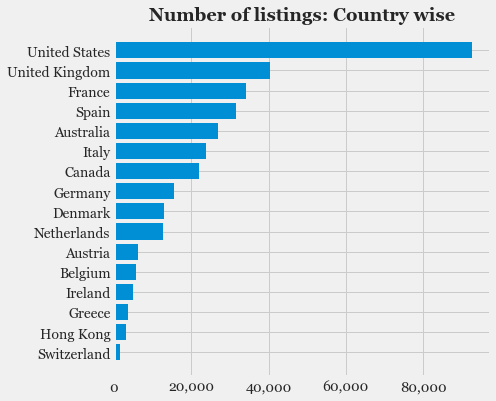

In [930]:
df1 = df.groupby("Country").count()["City"].reset_index().sort_values("City", ascending=False)
df1

plt.figure(figsize=(6,6))
plt.barh(df1["Country"], df1["City"])
ax = plt.gca()
ax.invert_yaxis()
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.title("Number of listings: Country wise", fontsize=18, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("images_predict_price/exploratory/histograms/country.png", bbox_inches='tight')

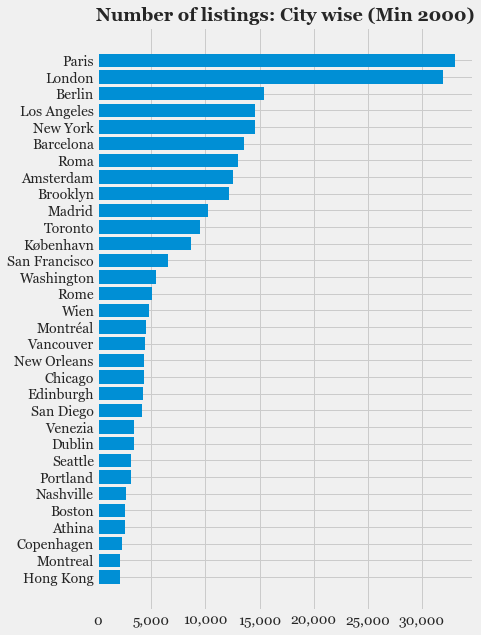

In [932]:
df1 = df.groupby("City").filter(lambda x: len(x)>2000).groupby("City").count()["Country"].reset_index().sort_values("Country", ascending=False)

plt.figure(figsize=(6,10))
plt.barh(df1["City"], df1["Country"])
ax = plt.gca()
ax.invert_yaxis()
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.title("Number of listings: City wise (Min 2000)", fontsize=18, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("images_predict_price/exploratory/histograms/city.png", bbox_inches='tight')


In [113]:
#df1 = df.groupby("Property Type").count()["City"].reset_index().sort_values("City", ascending=False)

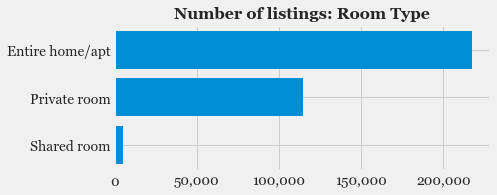

In [933]:
df1 = df.groupby("Room Type").count()["City"].reset_index().sort_values("City", ascending=False)

plt.figure(figsize=(6,2.5))
plt.barh(df1["Room Type"], df1["City"])
ax = plt.gca()
ax.invert_yaxis()
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.title("Number of listings: Room Type", fontsize=16, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("images_predict_price/exploratory/histograms/roomtype.png", bbox_inches='tight')

#### Bivariate analysis

In [ ]:
##### Correlation with price
# Price - Room Type
# Price - Country 
# Price - City
# Price - Neighbourhood
# Price - Review Scores Rating
# PRice - Host Since Days
# Price - Host Response Time
# Price - Host Response Rate
# Price - Host Is Superhost
# Price - Host Has Profile Pic
# Price - Amenities (TV, Internet, Air conditioning, Free parking on premises, 24-hour check-in)

#### Room type and price

In [322]:
import seaborn as sns

In [325]:
df["Room Type"].unique()

array(['Shared room', 'Entire home/apt', 'Private room'], dtype=object)

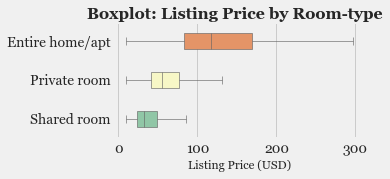

In [934]:
#df.groupby("Room Type").mean()["Price"].reset_index().sort_values("Price", ascending=False)

plt.figure(figsize=(4, 2))
dft = df[["Room Type", "Price"]]
#dft.boxplot(by="Room Type", vert=False, showfliers=False)
sns.boxplot(x='Price', y='Room Type', data=dft, order=['Entire home/apt', 'Private room', 'Shared room'],
            showfliers = False, palette="Spectral", linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle("Boxplot: Listing Price by Room-type", fontweight="bold", fontsize=16)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/roomtype_price.png", bbox_inches='tight')

##### Country and price

In [312]:
"""
import random
n = 100
# this is probably a strange way to generate random data; please feel free to correct it
df = pd.DataFrame({"X": [random.choice(["A","B","C"]) for i in range(n)], 
                   "Y": [random.choice(["a","b","c"]) for i in range(n)],
                   "Z": [random.gauss(0,1) for i in range(n)]})
grouped = df.groupby(["X", "Y"])

df2 = pd.DataFrame({col:vals['Z'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
df2 = df2[meds.index]
#df2.boxplot()

meds
"""
print("")

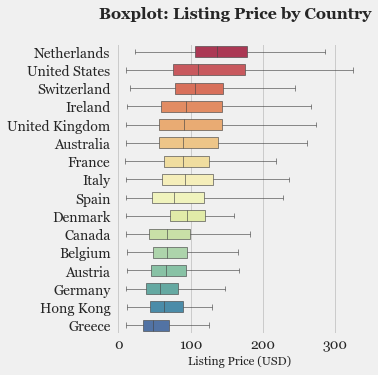

In [936]:
df1 = df.groupby("Country").mean()["Price"].reset_index().sort_values("Price", ascending=False)

plt.figure(figsize=(4,5))
dft = df[["Country", "Price"]].copy()
sns.boxplot(x='Price', y='Country', data=dft, order=df1["Country"].values,
            showfliers = False, palette="Spectral", linewidth=0.6, width=0.6)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle("Boxplot: Listing Price by Country", fontweight="bold", fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 5)

plt.savefig("images_predict_price/exploratory/correlation_with_price/country_price.png", bbox_inches='tight')

##### City and Price

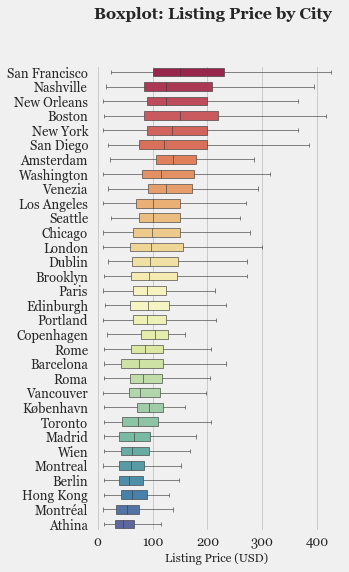

In [942]:
df1 = df.groupby("City").filter(lambda x: len(x)>2000).groupby("City").mean()["Price"].reset_index().sort_values("Price", ascending=False)

dft = df[["City", "Price"]].copy()
#dft = dft.groupby("City").filter(lambda x: len(x)>500)
plt.figure(figsize=(4,8))
#dft.boxplot(by="City", vert=False, showfliers=False)
sns.boxplot(x='Price', y='City', data=dft, order=df1["City"].values,
            showfliers = False, palette="Spectral", linewidth=0.6, width=0.6)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle("Boxplot: Listing Price by City", fontweight="bold", fontsize=16)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(13)

plt.savefig("images_predict_price/exploratory/correlation_with_price/city_price.png", bbox_inches='tight')

In [214]:
df.columns

Index(['Country', 'City', 'Neighbourhood Cleansed', 'Property Type',
       'Room Type', 'Accommodates', 'Bedrooms', 'Beds', 'Bed Type',
       'Cancellation Policy',
       ...
       'Cleaning before checkout', 'Wide hallway clearance', 'Wide doorway',
       'Flat smooth pathway to front door', 'Path to entrance lit at night',
       'Disabled parking spot', 'Accessible-height bed',
       'Free parking on street', 'Pocket wifi',
       'Local Currency to USD Factor'],
      dtype='object', length=158)

In [943]:
dfc = pd.DataFrame(df.corr(method="pearson")["Price"])
dfc.reset_index(inplace=True)
dfc.columns = ["features", "correlation_with_price"]
dfc.sort_values("correlation_with_price", ascending=False)
df1 = dfc[dfc["correlation_with_price"] > 0.1]
corr_features = df1["features"].values
corr_features.tolist().append("Price")
df1

,features,correlation_with_price
0,Accommodates,0.578864
1,Bedrooms,0.544936
2,Beds,0.467035
15,Review Scores Location,0.117533
19,Price,1.000000
29,TV,0.217739
33,Family/kid friendly,0.189181
34,Washer,0.101859
35,Smoke detector,0.111388
36,Fire extinguisher,0.105447


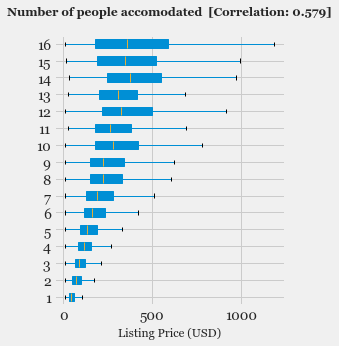

In [947]:
col = "Accommodates"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of people accomodated  [Correlation: " + str(cov) + "]"
plt_name = "accommodates"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

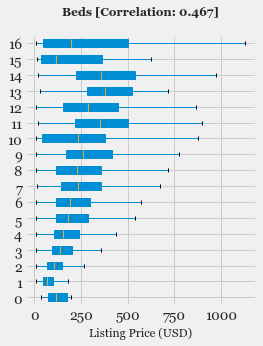

In [948]:
col = "Beds"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Beds [Correlation: " + str(cov) + "]"
plt_name = "beds"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

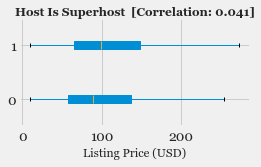

In [949]:
col = "Host Is Superhost"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Is Superhost  [Correlation: " + str(cov) + "]"
plt_name = "superhost"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

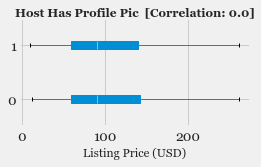

In [950]:
col = "Host Has Profile Pic"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Has Profile Pic  [Correlation: " + str(cov) + "]"
plt_name = "profilepic"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

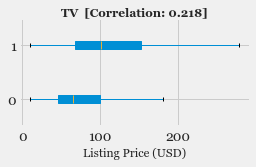

In [951]:
col = "TV"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "TV  [Correlation: " + str(cov) + "]"
plt_name = "tv"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

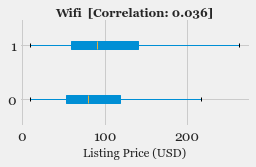

In [952]:
col = "Wireless Internet"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Wifi  [Correlation: " + str(cov) + "]"
plt_name = "wifi"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

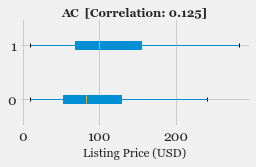

In [953]:
col = "Air conditioning"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "AC  [Correlation: " + str(cov) + "]"
plt_name = "ac"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

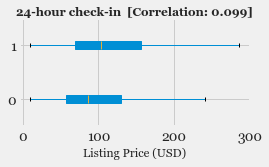

In [954]:
col = "24-hour check-in"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "24-hour check-in  [Correlation: " + str(cov) + "]"
plt_name = "24hourcheckin"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

In [451]:
df1

,features,correlation_with_price
0,Accommodates,0.576861
1,Bedrooms,0.544661
2,Beds,0.462673
15,Review Scores Location,0.111835
19,Price,1.000000
29,TV,0.220063
33,Family/kid friendly,0.191935
35,Smoke detector,0.119133
36,Fire extinguisher,0.113585
38,Cable TV,0.236224


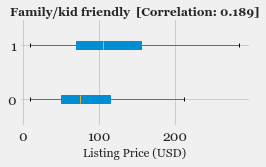

In [955]:
col = "Family/kid friendly"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Family/kid friendly  [Correlation: " + str(cov) + "]"
plt_name = "family"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

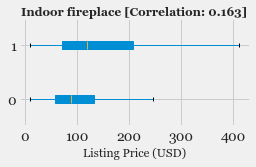

In [956]:
col = "Indoor fireplace"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Indoor fireplace [Correlation: " + str(cov) + "]"
plt_name = "fireplace"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

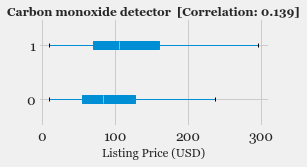

In [957]:
col = "Carbon monoxide detector"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Carbon monoxide detector  [Correlation: " + str(cov) + "]"
plt_name = "firedetector"

dft = df[[col, "Price"]].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,2), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title("")
ax.set_xlabel("Listing Price (USD)", fontsize=12)
ax.set_ylabel("")
plt.suptitle(suptitle, fontweight="bold", fontsize=12)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 6)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

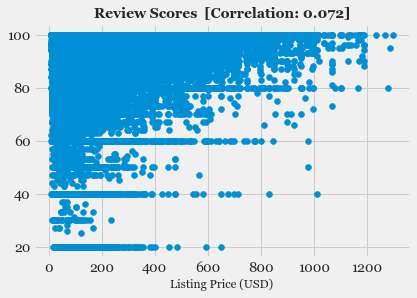

In [958]:
col = "Review Scores Rating"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
title = "Review Scores  [Correlation: " + str(cov) + "]"
plt_name = "review"

plt.scatter(df["Price"], df[col])

ax = plt.gca()
#ax.invert_yaxis()
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.title(title, fontsize=14, fontweight="bold") 
ax.set_xlabel("Listing Price (USD)", fontsize=12)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

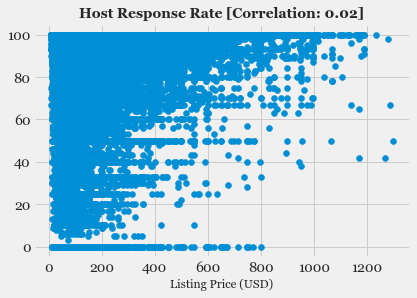

In [959]:
#plt.scatter(df["Host Response Rate"], df["Price"])

col = "Host Response Rate"
cov = np.round(dfc[dfc["features"]==col]["correlation_with_price"].values[0], 3)
title = "Host Response Rate [Correlation: " + str(cov) + "]"
plt_name = "hostresponserate"

plt.scatter(df["Price"], df[col])

ax = plt.gca()
#ax.invert_yaxis()
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.title(title, fontsize=14, fontweight="bold") 
ax.set_xlabel("Listing Price (USD)", fontsize=12)

plt.savefig("images_predict_price/exploratory/correlation_with_price/"+plt_name+"_price.png", bbox_inches='tight')

In [ ]:
##### Other possible interesting matchups
# City/Neighbourhood - Review Scores Rating
# City/Neighbourhood - Availability 30/365
# City/Neighbourhood - Calculated host listings count

##### New features
# City vs Estimated income = (30 - Availability 30) * PricePerNight 

In [960]:
dft = df[["City", "Review Scores Rating"]].copy()
dft.groupby("City").filter(lambda x: len(x)>500).groupby("City").mean().reset_index().sort_values("Review Scores Rating", ascending=False)

,City,Review Scores Rating
37,Portland,96.395765
30,Nashville,96.115471
12,Denver,95.917988
31,New Orleans,95.476902
10,Chicago,95.129025
22,Long Beach,94.949807
55,West Hollywood,94.921348
54,Washington,94.828872
3,Athina,94.669146
46,Southbank,94.609346


In [961]:
col = "Availability 30"
dft = df[["City", col]].copy()
dft.groupby("City").filter(lambda x: len(x)>500).groupby("City").mean().reset_index().sort_values(col, ascending=True)

,City,Availability 30
0,Amsterdam,2.188547
20,København,4.846903
15,Frederiksberg,4.940864
11,Copenhagen,5.152060
5,Berlin,5.496824
41,Saint-Gilles,6.289628
32,New York,6.366561
50,Venezia,6.567850
47,Surry Hills,6.808682
4,Barcelona,6.929394


In [962]:
col = "Calculated host listings count"
dft = df[["City", col]].copy()
dft.groupby("City").filter(lambda x: len(x)>500).groupby("City").mean().reset_index().sort_values(col, ascending=False)

,City,Calculated host listings count
7,Boston,10.399303
18,Hong Kong,10.013862
21,London,9.141587
51,Venice,8.626343
50,Venezia,8.622726
34,Palma,8.411126
27,Melbourne,8.333333
9,Bruxelles,7.449848
35,Palma de Mallorca,7.210769
46,Southbank,6.936449


#### Exploratory analysis conclusions

#### Combined pipeline for both numerical and categorical features

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer


##########################################################
############ Pipeline for numerical features #############
# Select numerical columns only
numerical_attribs = [   'Accommodates', 'Bedrooms', 'Beds', 'Minimum Nights',
             'Availability 30', 'Availability 60', 'Availability 90',
             'Availability 365', 'Number of Reviews', 'Reviews per Month',
             'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness',
             'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location',
             'Review Scores Value', 'Host Response Rate']
#df_num = df.select_dtypes(include=[np.number])
numerical_pipeline = Pipeline([
        #('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])
#df_num_tr = numerical_pipeline.fit_transform(df_num)
#df_num_tr
##########################################################


##########################################################
########## Pipeline for categorical features #############
categorical_attribs = ["Country", "City", "Neighbourhood Cleansed",
                    "Property Type", "Room Type", "Bed Type", "Cancellation Policy",
                    "Host Response Time"]
#df_cat = df[categorical_columns]

# Encode categorical features as integers
# ordinal_encoder = OrdinalEncoder()
# df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
categorical_pipeline = Pipeline([
                            ('ordinal_encoder', OrdinalEncoder()),
                            ])
##########################################################


##########################################################
########## Combined Pipeline for all features ############
preprocessing_pipeline = ColumnTransformer([
        ("categorical", categorical_pipeline, categorical_attribs),
        ("numerical", numerical_pipeline, numerical_attribs),
    ])

label = ["Price"]

df_attribs = df[categorical_attribs + numerical_attribs + label].copy()
df_prepared = preprocessing_pipeline.fit_transform(df[categorical_attribs + numerical_attribs])

# Save preprocessing pipeline
#save_model(model=preprocessing_pipeline, save_path="../webapp/static/model/preprocessing_pipeline.pkl")
##########################################################

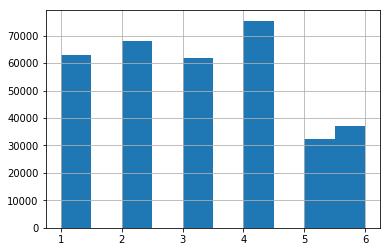

In [11]:
### Price Categories (in USD)
# 1:10-50 2:50-75 3:75-100 4:100-150 5:150-200 6:>200
df_attribs["Price Label"] = pd.cut(df["Price"],
                           bins=[0., 50., 75., 100.0, 150., 200., np.inf],
                           labels=[1, 2, 3, 4, 5, 6])

# Distribution of class labels in overall dataset
df_attribs["Price Label"].hist()

### Split Dataset into train and test sets

In [12]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

df_attribs.reset_index(inplace=True)
del df_attribs["index"]

"""
dfx = df.copy()
del dfx["Price"]
dfy = df["Price"].copy()
x_train, x_test, y_train, y_test = train_test_split(dfx,dfy, test_size=0.1, random_state=42)
"""

# Stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df_attribs, df_attribs["Price Label"]):
    strat_train_set = df_attribs.loc[train_index]
    strat_test_set = df_attribs.loc[test_index]

### Univariate, scatter matrix analysis

In [14]:
df_strat_train = strat_train_set.copy()

#from pandas.plotting import scatter_matrix
#attributes = ["Review Scores Rating", "Price"]
#scatter_matrix(df[attributes], figsize=(12, 8))

### Prepare the data for Machine Learning algorithms

In [13]:
# drop labels for training set
df = strat_train_set.drop(["Price", "Price Label"], axis=1) 
df_labels = strat_train_set["Price"].copy()

In [19]:
round(len(df_attribs) * 0.1)

33757

In [36]:
nprice = strat_train_set.groupby("Neighbourhood Cleansed").mean()["Price"].reset_index()
nprice.rename(columns={"Price":"Neighbourhood Avg Price"}, inplace=True)
nprice

,Neighbourhood Cleansed,Neighbourhood Avg Price
0,1Ο ΝΕΚΡΟΤΑΦΕΙΟ,63.202222
1,Abbeyhill,111.853425
2,Abrantes,34.113333
3,Acacias,53.136632
4,Adams,128.673077
5,Adams Point,100.558824
6,Adams-Normandie,63.148148
7,Adelfas,64.645946
8,Adlershof,43.732500
9,Agincourt North,26.030000


#### Handling missing values

In [ ]:
"""
# Check if there are any rows with NULL values
sample_incomplete_rows = df[df.isnull().any(axis=1)] #.head()
len(sample_incomplete_rows)

# Option 1: Remove rows with NULL values for any subset of columns
# sample_incomplete_rows.dropna(subset=["Bedrooms"])

# Option 2: Remove columns with NULL values
# sample_incomplete_rows.drop("Bedrooms", axis=1)

# Option 3: Fill NULL values with median values of corresponding columns

### Method 1: Manual
# median = df["Bedrooms"].median()
# sample_incomplete_rows["Bedrooms"].fillna(median, inplace=True)

### Method 2: sklearn in-built (Works when all numerical columns NULL is to be replaced with median)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# Select numerical columns only
df_num = df_xtrain.select_dtypes(include=[np.number])
imputer.fit(df_num)
X = imputer.transform(df_num)
Xtrain = pd.DataFrame(X, columns=df_num.columns,
                          index=df_num.index)
"""

#### Adding extra features 

In [ ]:
"""
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
df_extra_attribs = attr_adder.fit_transform(df.values)
"""

## Exploratory analysis, feature selection

## Model training and selection

In [ ]:
### Model training and selection pipeline

# Model selection
## For each ML Model
#### 1. Use Grid Search or Randomized search to find best parameters (get_hyperparameter_search_results)
#### 2. Plots to show how CV mean score varies by varying different parameters
####        For each parameter being searched, fix all but one parameter, plot rmse vs one varying parameter
#### 3. Plots to show feature importance
#### 4. Save best estimator

# Model comparison
## For each ML Model
#### 1. Get test RMSE results, mean, SE, 95%_ci etc (get_test_results)
## Visualise models (?)
####    https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
####    Actual labels vs predicted values (show best fit line with confidence_interval)  -- use different colors for different ML models
####    Residuals vs predicted values
####    Different regression metrics (R2, MSE, MAE, Variance explained etc)
## Visualise box plots of test results from all models
####    https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
## Choose the best model and save for serving using Flask

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.externals import joblib
import joblib

def save_model(save_path, model):
    joblib.dump(model, save_path) # DIFF    

def load_model(load_path):
    my_model_loaded = joblib.load(load_path)
    return my_model_loaded
    
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    

# Function to get grid search results
def get_hyperparameter_search_results(model, df_train, df_labels, search_type,
                                      param_grid, param_distributions, n_iter, cv):
    """
    Get hyperparameter search results
    @params
        model:        ML Model
        df_train      Input features (pre-processed)
        df_labels:    Labels
        search_type:  "grid", "randomized"
        param_grid:   List of dictionaries with parameters to be searched over
    @returns
        search_results: with following fields
            ["search", "best_params_", "best_estimator_", "cv_results_"]
    """
    search_results = {}
    
    ## train across 5 folds, that's a total of (12+6)*5=90 rounds of training
    if search_type == "grid":
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                              scoring='neg_mean_squared_error', return_train_score=True)
    elif search_type == "randomized":
        search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                    n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error', random_state=42,
                                    return_train_score=True)
    else:
        print("Invalid search type")
        return

    search.fit(df_train, df_labels)

    # Best estimator (hyperparameter combination) found
    #search.best_params_
    #search.best_estimator_

    # score of each hyperparameter combination tested during the grid search
    # cvres = grid_search.cv_results_
    # for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #    print(np.sqrt(-mean_score), params)
    
    search_results["search"] = search
    search_results["best_params_"] = search.best_params_
    search_results["best_estimator_"] = search.best_estimator_
    search_results["cv_results_"] = search.cv_results_
    
    return search_results


def plot_feature_importance(best_estimator, df_train):
    """
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    TODO: Can plot horizontal bars too
    """
    #forest.fit(X, y)
    #importances = forest.feature_importances_
    X = df_train
    importances = best_estimator.feature_importances_

    #std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    #print("Feature ranking:")
    #for f in range(X.shape[1]):
    #    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    #        color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [21]:
from sklearn.model_selection import learning_curve
def get_model_pics(model, model_save_name, train_sizes_lc, train_sizes_fittime, ylim):
    
    train_sizes, train_scores, valid_scores, fit_times, score_times = learning_curve(model, df_prepared, df_labels,
                                                            train_sizes=train_sizes_lc, cv=5,
                                                            #train_sizes=[0.25, 0.5, 0.75, 1], cv=5,
                                                            scoring="neg_mean_squared_error", return_times=True)
    
    train_rmse = np.sqrt(-train_scores)
    train_rmse_mean = np.mean(train_rmse, axis=1)
    train_rmse_std = np.std(train_rmse, axis=1)

    valid_rmse = np.sqrt(-valid_scores)
    valid_rmse_mean = np.mean(valid_rmse, axis=1)
    valid_rmse_std = np.std(valid_rmse, axis=1)

    
    ### Learning Curve
    plt.figure()
    plt.plot(train_sizes, train_rmse_mean, 'o-', linewidth=2, markersize=8)
    plt.fill_between(train_sizes, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5)
    plt.plot(train_sizes, valid_rmse_mean, 'o-', linewidth=2, markersize=8)
    plt.fill_between(train_sizes, valid_rmse_mean-2*valid_rmse_std, valid_rmse_mean+2*valid_rmse_std, alpha=0.5)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.title("Learning Curve: Linear Regression", fontsize=16, fontweight="bold")
    plt.xlabel("Number of training examples", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.legend(["Training", "Validation"])
    plt.savefig("images_predict_price/exploratory/models/"+model_save_name+"_lc.png", bbox_inches="tight")

    
    ### Scalability of models
    train_sizes, train_scores, valid_scores, fit_times, score_times = learning_curve(model, df_prepared, df_labels,
                                                            train_sizes=train_sizes_fittime, cv=5,
                                                            #train_sizes=[0.25, 0.5, 0.75, 1], cv=10,
                                                            scoring="neg_mean_squared_error", return_times=True)

    valid_rmse = np.sqrt(-valid_scores)
    valid_rmse_mean = np.mean(valid_rmse, axis=1)
    valid_rmse_std = np.std(valid_rmse, axis=1)

    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    plt.figure()
    plt.plot(train_sizes, fit_times_mean, 'o-', linewidth=2, markersize=8, c="#e5ae38")
    plt.fill_between(train_sizes, fit_times_mean-2*fit_times_std, fit_times_mean+2*fit_times_std, alpha=0.5, color="#e5ae38")
    ax = plt.gca()
    ax.set_xscale('log')
    plt.title("Model Scalability: Linear Regression", fontsize=16, fontweight="bold")
    plt.xlabel("Number of training examples", fontsize=14)
    plt.ylabel("Time to fit (seconds)", fontsize=14)
    #plt.ylim(ylim)
    plt.savefig("images_predict_price/exploratory/models/"+model_save_name+"_fittime.png", bbox_inches="tight")
    
    
    ### Model performance
    plt.figure()
    plt.plot(fit_times_mean, train_rmse_mean, 'o-', linewidth=2, markersize=8, c="#6d904f")
    plt.fill_between(fit_times_mean, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5, color="#6d904f")
    plt.title("Model Performance: Linear Regression", fontsize=16, fontweight="bold")
    plt.ylabel("Training RMSE", fontsize=14)
    plt.xlabel("Time to fit (seconds)", fontsize=14)
    plt.savefig("images_predict_price/exploratory/models/"+model_save_name+"_perf.png", bbox_inches="tight")

In [481]:
# Load preprocessing model
#preprocessing_pipeline = load_model(load_path="../webapp_predict_price/static/model/preprocessing_pipeline.pkl")

In [24]:
df_labels.values

array([178.5 , 188.5 , 201.  , ...,  65.45, 142.8 ,  80.  ])

### Baseline Models

#### Neighbourhood Average price

In [56]:
dfnavg = strat_train_set[["Neighbourhood Cleansed", "Price"]].set_index("Neighbourhood Cleansed").join(nprice.set_index("Neighbourhood Cleansed")).reset_index()
dfnavg["error"] = dfnavg["Price"] - dfnavg["Neighbourhood Avg Price"]
predictions = dfnavg["Neighbourhood Avg Price"]
labels = dfnavg["Price"]
mse_navg = mean_squared_error(labels, predictions)
rmse_navg = np.sqrt(mse_navg)
print("RMSE: " + str(rmse_navg))

RMSE: 85.28369466826953


In [73]:
rmsescores_navg = np.sqrt((labels - predictions)**2)

In [62]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
rmsescores_navg = []
for train_index, test_index in kf.split(strat_train_set):
    mse_navg = mean_squared_error(labels[test_index], predictions[test_index])
    rmse_navg = np.sqrt(mse_navg)
    #print("RMSE: " + str(rmse_navg))
    rmsescores_navg.append(rmse_navg)
rmsescores_navg = np.array(rmsescores_navg)
display_scores(rmsescores_navg)

Scores: [77.57918664 98.27056249 79.47312371 85.67007463 90.67272979 84.80945044
 79.54886767 85.63864363 85.70642788 83.54816438]
Mean: 85.0917231270523
Standard deviation: 5.718682354386583


#### K-Nearest Neighbors Regressor

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

neigh = KNeighborsRegressor(n_neighbors=100)
df_prepared = preprocessing_pipeline.transform(df)
neigh.fit(df_prepared, df_labels)
df_predictions = neigh.predict(df_prepared)
mse_knn = mean_squared_error(df_labels, df_predictions)
rmse_knn = np.sqrt(mse_knn)
print("RMSE: " + str(rmse_knn))

RMSE: 74.13673824817661


In [37]:
scores_knn = cross_val_score(neigh, df_prepared, df_labels,
                             scoring="neg_mean_squared_error", cv=10)
rmsescores_knn = np.sqrt(-scores_knn)
display_scores(rmsescores_knn)

Scores: [75.59809232 77.91050072 74.52380876 73.45573104 74.97879612 75.5458374
 75.94194226 75.4785825  75.38882914 76.45327842]
Mean: 75.52753986663531
Standard deviation: 1.1106377090848187


#### Linear Regression

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model_linreg = LinearRegression()
df_prepared = preprocessing_pipeline.transform(df)
model_linreg.fit(df_prepared, df_labels)
#df_predictions = model_linreg.predict(df_prepared)

pipeline_linreg = Pipeline([
        ("preparation", preprocessing_pipeline),
        ("linear", model_linreg)
    ])
df_predictions = pipeline_linreg.predict(df)

mse_linreg = mean_squared_error(df_labels, df_predictions)
rmse_linreg = np.sqrt(mse_linreg)
print("RMSE: " + str(rmse_linreg))

mae_linreg = mean_absolute_error(df_labels, df_predictions)
print("MAE: " + str(mae_linreg))

r2score = r2_score(df_labels, df_predictions)
print("R2 Score: " + str(r2score))

# Cross Validation
#scores_linreg = cross_val_score(pipeline_linreg, df, df_labels,
scores_linreg = cross_val_score(model_linreg, df_prepared, df_labels,
                             scoring="neg_mean_squared_error", cv=10)
rmsescores_linreg = np.sqrt(-scores_linreg)
display_scores(rmsescores_linreg)

# Save full pipeline (pre-processing + Model)
#save_model(model=pipeline_linreg, save_path="../webapp/static/model/fullpipeline_linearregression.pkl")

RMSE: 69.41824502674898
MAE: 43.009284154809045
R2 Score: 0.4666003805657244
Scores: [70.07726632 71.27189689 68.33640515 68.20023135 69.94587253 69.45683366
 69.14793134 69.3443412  69.02414467 69.42497526]
Mean: 69.4229898370586
Standard deviation: 0.8389168918470272


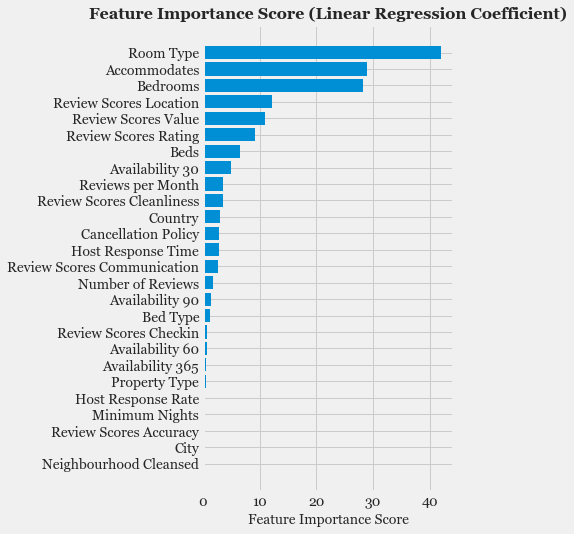

In [972]:
features = df.columns
score = abs(importance)
features_sorted = [x for y,x in sorted(zip(score, features))]
score_sorted = [y for y,x in sorted(zip(score, features))]

plt.figure(figsize=(4,8))
plt.barh(features_sorted, score_sorted)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance Score (Linear Regression Coefficient)", fontsize=16, fontweight="bold")
plt.savefig("images_predict_price/exploratory/models/linreg_featurescore.png", bbox_inches="tight")

In [737]:
### Feature Selection

from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
#X_new = SelectKBest(f_regression, k=5).fit_transform(df_prepared, df_labels)
#X_new.shape

rfe = RFE(estimator=model_linreg, n_features_to_select=5, step=1)
rfe.fit(df_prepared, df_labels)
ranking = rfe.ranking_ #.reshape(digits.images[0].shape)
ranking

array([ 8, 21, 22, 16,  1, 13,  9, 10,  1,  1,  4, 19,  3, 14, 12, 17, 11,
        5,  2, 20,  6, 15,  7,  1,  1, 18])

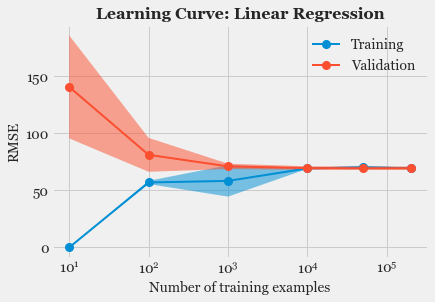

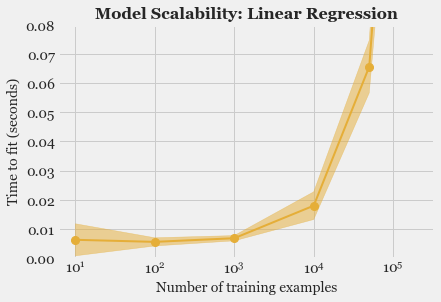

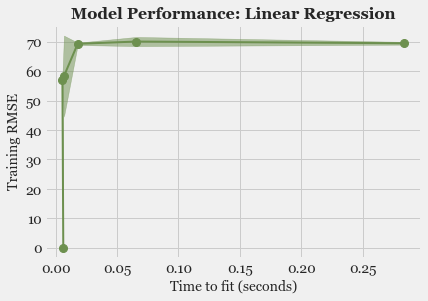

In [976]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(model_linreg, "linreg", [10, 100, 1000, 10000, 50000, 200000],
               [10, 100, 1000, 10000, 50000, 200000], [0, 0.08])

In [483]:
df_attribs.columns

Index(['Country', 'City', 'Neighbourhood Cleansed', 'Property Type',
       'Room Type', 'Bed Type', 'Cancellation Policy', 'Host Response Time',
       'Accommodates', 'Bedrooms', 'Beds', 'Minimum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Number of Reviews', 'Reviews per Month', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'Host Response Rate',
       'Price', 'Price Label'],
      dtype='object')

#### Decision Tree Regressor

In [46]:
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
"""
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(df_prepared, df_labels)

df_predictions = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

# Cross Validation
scores = cross_val_score(tree_reg, df_prepared, df_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)
"""

print("========= Decision Tree Regressor ====================")
default_model_dectree = DecisionTreeRegressor(random_state=42)
default_model_dectree.fit(df_prepared, df_labels)
df_predictions = default_model_dectree.predict(df_prepared)
"""
#mse_default_model_dectree = mean_squared_error(df_labels, df_predictions)
#rmse_default_model_dectree = np.sqrt(mse_default_model_dectree)
#print("Model: ")
#print(default_model_dectree)
#print("Default Model RMSE Score: " + str(rmse_default_model_dectree))
"""
#scores = cross_val_score(default_model_dectree, df_prepared, df_labels,
#                         scoring="neg_mean_squared_error", cv=10)
#tree_rmse_scores = np.sqrt(-scores)
#display_scores(tree_rmse_scores)


model_dectree = DecisionTreeRegressor(random_state=42)
"""
param_distribs = {
        'max_depth': randint(low=1, high=10),
        'max_features': randint(low=1, high=20),
    }
"""
param_grid = [
    {'max_depth': [1, 20, 100], 'max_features': [1, 5, 15, 20], 'max_leaf_nodes': [5, 50, 100]},
  ]
search_results_dectree = get_hyperparameter_search_results(model=model_dectree, df_train=df_prepared,
                                                           df_labels=df_labels, search_type="grid",
                                                           param_grid=param_grid, param_distributions=None,
                                                           #param_grid=[], param_distributions=param_distribs,
                                                           n_iter=5, cv=2)

# Best estimator (hyperparameter combination) found
print("======Best Parameters: ======")
print(search_results_dectree["best_params_"])
print("======Best Estimator: ======")
print(search_results_dectree["best_estimator_"])

print("====== Cross Validation Results ======")
# score of each hyperparameter combination tested during the grid search
cvres = search_results_dectree["cv_results_"]
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
best_dectree = search_results_dectree["best_estimator_"]

========= Decision Tree Regressor ====================
======Best Parameters: ======
{'max_depth': 20, 'max_features': 20, 'max_leaf_nodes': 100}
======Best Estimator: ======
DecisionTreeRegressor(max_depth=20, max_features=20, max_leaf_nodes=100,
                      random_state=42)
====== Cross Validation Results ======
95.00433094412635 {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 5}
95.00433094412635 {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 50}
95.00433094412635 {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 100}
82.80935361170523 {'max_depth': 1, 'max_features': 5, 'max_leaf_nodes': 5}
82.80935361170523 {'max_depth': 1, 'max_features': 5, 'max_leaf_nodes': 50}
82.80935361170523 {'max_depth': 1, 'max_features': 5, 'max_leaf_nodes': 100}
82.80935361170523 {'max_depth': 1, 'max_features': 15, 'max_leaf_nodes': 5}
82.80935361170523 {'max_depth': 1, 'max_features': 15, 'max_leaf_nodes': 50}
82.80935361170523 {'max_depth': 1, 'max_features': 15, 'max_leaf_

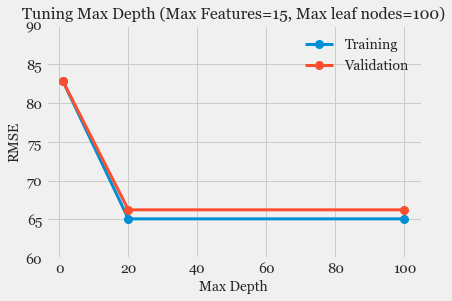

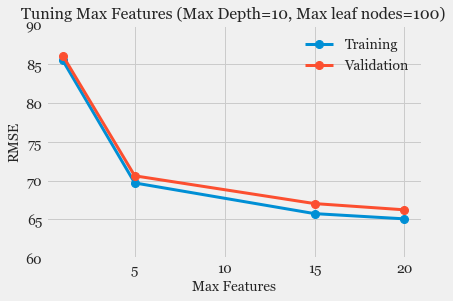

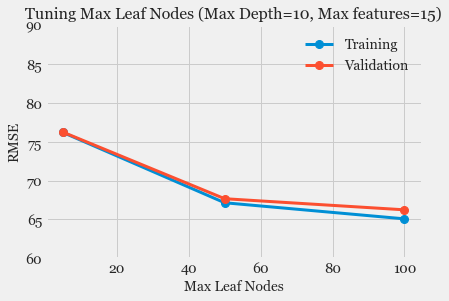

In [980]:
### Hyperparameter tuning

### Max Depth
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_features = 20
max_leaf_nodes = 100
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_features"]==max_features) and (params["max_leaf_nodes"]==max_leaf_nodes):
        hparams.append(params["max_depth"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([60, 90])
plt.title("Tuning Max Depth (Max Features=15, Max leaf nodes=100)", fontsize=16)
plt.savefig("images_predict_price/exploratory/hparams/dectree_maxdepth.png", bbox_inches="tight")


### Max Depth
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 20
max_leaf_nodes = 100
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_leaf_nodes"]==max_leaf_nodes):
        hparams.append(params["max_features"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Features", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([60, 90])
plt.title("Tuning Max Features (Max Depth=10, Max leaf nodes=100)", fontsize=16)
plt.savefig("images_predict_price/exploratory/hparams/dectree_maxfeatures.png", bbox_inches="tight")


### Max leaf nodes
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 20
max_features = 20
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_features"]==max_features):
        hparams.append(params["max_leaf_nodes"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Leaf Nodes", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([60, 90])
plt.title("Tuning Max Leaf Nodes (Max Depth=10, Max features=15)", fontsize=16)
plt.savefig("images_predict_price/exploratory/hparams/dectree_maxleafnodes.png", bbox_inches="tight")

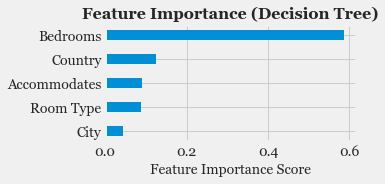

In [982]:
### Feature importance
features = df.columns
score = best_dectree.feature_importances_
features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(4,2))
plt.barh(features_sorted[:5][::-1], score_sorted[:5][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (Decision Tree)", fontsize=16, fontweight="bold")
plt.savefig("images_predict_price/exploratory/models/dectree_featurescore.png", bbox_inches="tight")

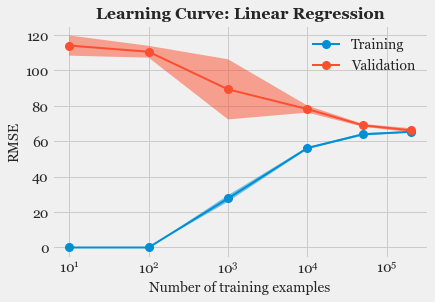

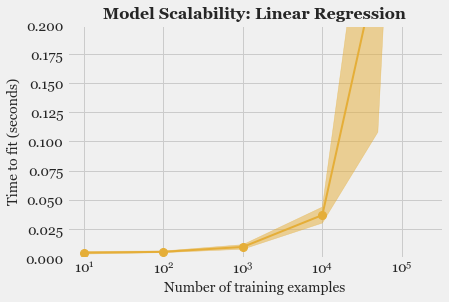

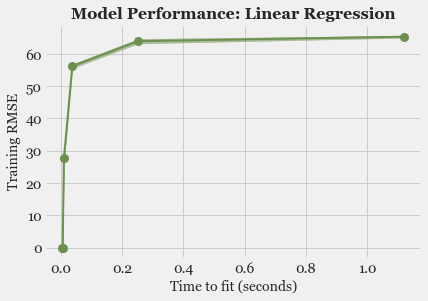

In [983]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(best_dectree, "dectree", [10, 100, 1000, 10000, 50000, 200000],
               [10, 100, 1000, 10000, 50000, 200000], [0, 0.2])

In [22]:
#bestmodel_dectree = search_results_dectree["best_estimator_"]
#save_model(model=bestmodel_dectree, save_path="../webapp/static/model/decision_tree.pkl")

#### Random Forest Regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from scipy import stats

####################################################################
####### Regression with set fixed values of model parameters #######
default_model_rf = RandomForestRegressor(n_estimators=10, random_state=42)
default_model_rf.fit(df_prepared, df_labels)
df_predictions = default_model_rf.predict(df_prepared)
mse_default_model_rf = mean_squared_error(df_labels, df_predictions)
rmse_default_model_rf = np.sqrt(mse_default_model_rf)
print(rmse_default_model_rf)
####################################################################


"""
####################################################################
##################### Cross Validation Scores ######################
forest_scores = cross_val_score(forest_reg, df_prepared, df_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)
####################################################################

####################################################################
############### Grid Search (to find best parameters) CV ###########
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
## train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(df_prepared, df_labels)

# Best estimator (hyperparameter combination) found
grid_search.best_params_
grid_search.best_estimator_

# score of each hyperparameter combination tested during the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
####################################################################


####################################################################
######### Randomized Search (to find best parameters) CV ###########
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(df_prepared, df_labels)

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
####################################################################
"""


model_rf = RandomForestRegressor(random_state=42)
#param_distribs = {
#        'max_depth': randint(low=1, high=10),
#        'max_features': randint(low=1, high=80),
#    }
param_grid = [
    {'n_estimators': [3, 10, 100], 'max_features': [2, 10, 20], 'max_depth': [2, 10, 100]},
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
search_results_rf = get_hyperparameter_search_results(model=model_rf, df_train=df_prepared,
                                                           df_labels=df_labels, search_type="grid",
                                                           param_grid=param_grid, param_distributions=[],
                                                           n_iter=5, cv=2)

best_rf = search_results_rf["best_estimator_"]

# Best estimator (hyperparameter combination) found
print("======Best Parameters: ======")
print(search_results_rf["best_params_"])
print("======Best Estimator: ======")
print(search_results_rf["best_estimator_"])

print("====== Cross Validation Results ======")
# score of each hyperparameter combination tested during the grid search
cvres = search_results_rf["cv_results_"]
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

####################################################################
###################### Feature Importance ##########################
#feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances = search_results_rf["best_estimator_"].feature_importances_
#feature_importances
attributes = numerical_attribs + categorical_attribs
#sorted(zip(feature_importances, attributes), reverse=True)
####################################################################

26.035965615805253
======Best Parameters: ======
{'max_depth': 100, 'max_features': 20, 'n_estimators': 100}
======Best Estimator: ======
RandomForestRegressor(max_depth=100, max_features=20, random_state=42)
====== Cross Validation Results ======
91.5962979062553 {'max_depth': 2, 'max_features': 2, 'n_estimators': 3}
85.02392991166467 {'max_depth': 2, 'max_features': 2, 'n_estimators': 10}
84.01326736522428 {'max_depth': 2, 'max_features': 2, 'n_estimators': 100}
75.33444824629454 {'max_depth': 2, 'max_features': 10, 'n_estimators': 3}
74.92230871391001 {'max_depth': 2, 'max_features': 10, 'n_estimators': 10}
75.17993081831932 {'max_depth': 2, 'max_features': 10, 'n_estimators': 100}
74.9827075053055 {'max_depth': 2, 'max_features': 20, 'n_estimators': 3}
74.82262745992345 {'max_depth': 2, 'max_features': 20, 'n_estimators': 10}
74.54498159697702 {'max_depth': 2, 'max_features': 20, 'n_estimators': 100}
71.90183276446247 {'max_depth': 10, 'max_features': 2, 'n_estimators': 3}
68.42068

In [ ]:
### Save best estimator to be used for serving (to get predictions)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

df_prepared = preprocessing_pipeline.transform(df)

save_rf = RandomForestRegressor(n_estimators=100, max_features=20, max_depth=100, random_state=42)
save_rf.fit(df_prepared, df_labels)
df_predictions = save_rf.predict(df_prepared)
mse_save_rf = mean_squared_error(df_labels, df_predictions)
rmse_save_rf = np.sqrt(mse_save_rf)
print("RMSE: " + str(rmse_save_rf))

pipeline_rf = Pipeline([
        ("preparation", preprocessing_pipeline),
        ("linear", save_rf)
    ])
# Save full pipeline (pre-processing + Model)
#save_model(model=pipeline_rf, save_path="../webapp_predict_price/static/model/fullpipeline_randomforest.pkl")

In [ ]:
#save_model(model=pipeline_rf, save_path="../webapp_predict_price/static/model/fullpipeline_randomforest.pkl")

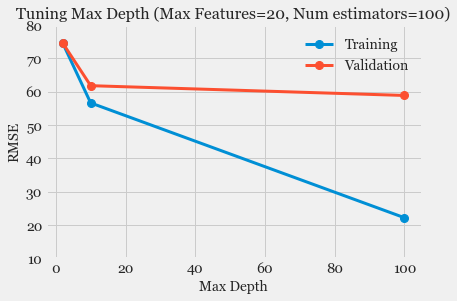

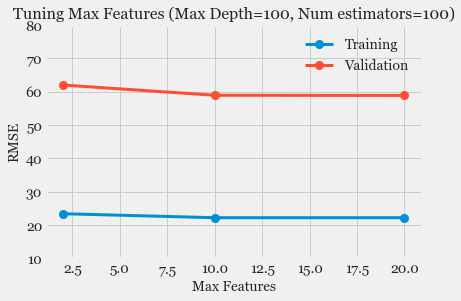

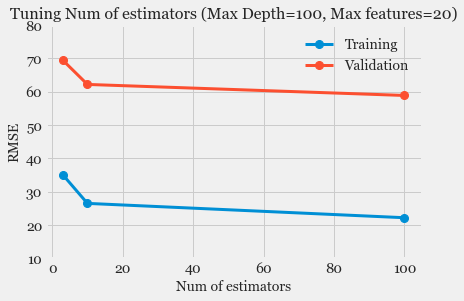

In [986]:
### Hyperparameter tuning

### Max Depth
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_features = 20
n_estimators = 100
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_features"]==max_features) and (params["n_estimators"]==n_estimators):
        hparams.append(params["max_depth"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([10, 80])
plt.title("Tuning Max Depth (Max Features="+str(max_features)+", Num estimators="+str(n_estimators)+")", fontsize=16)
plt.savefig("images_predict_price/exploratory/hparams/rf_maxdepth.png", bbox_inches="tight")


### Max Depth
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 100
n_estimators = 100
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["n_estimators"]==n_estimators):
        hparams.append(params["max_features"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Features", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([10, 80])
plt.title("Tuning Max Features (Max Depth="+str(max_depth)+", Num estimators="+str(n_estimators)+")", fontsize=16)
plt.savefig("images_predict_price/exploratory/hparams/rf_maxfeatures.png", bbox_inches="tight")


### Max leaf nodes
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 100
max_features = 20
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_features"]==max_features):
        hparams.append(params["n_estimators"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Num of estimators", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([10, 80])
plt.title("Tuning Num of estimators (Max Depth="+str(max_depth)+", Max features="+str(max_features)+")", fontsize=16)
plt.savefig("images_predict_price/exploratory/hparams/rf_nestimators.png", bbox_inches="tight")

In [989]:
cvres

{'mean_fit_time': array([1.31542444e-01, 3.84621859e-01, 4.13840103e+00, 4.50475574e-01,
        1.35716009e+00, 1.19743001e+01, 9.27221537e-01, 2.00990403e+00,
        2.17543421e+01, 3.32579017e-01, 1.50538242e+00, 1.19562830e+01,
        1.18370581e+00, 4.73449183e+00, 4.35507814e+01, 3.83814692e+00,
        6.75939000e+00, 8.22855026e+01, 1.24100709e+00, 2.85941255e+00,
        2.99020405e+01, 1.99941659e+00, 6.74016356e+00, 9.61011156e+01,
        5.00056148e+00, 1.78815856e+01, 2.16869088e+02]),
 'std_fit_time': array([3.57341766e-03, 6.02111816e-02, 1.75637007e-01, 1.22162461e-01,
        6.55090809e-02, 5.98458052e-01, 3.57937813e-03, 3.19311023e-01,
        1.70514202e+00, 1.00430250e-02, 3.79863977e-02, 1.32592690e+00,
        4.90639210e-02, 6.69547081e-01, 1.00339884e+01, 6.81793928e-01,
        7.05599189e-01, 1.96838152e+00, 4.44591999e-01, 1.13536119e-02,
        3.11141253e+00, 3.05764675e-02, 1.40648365e-01, 2.30994304e+01,
        2.04460382e-01, 1.36075139e+00, 4.460

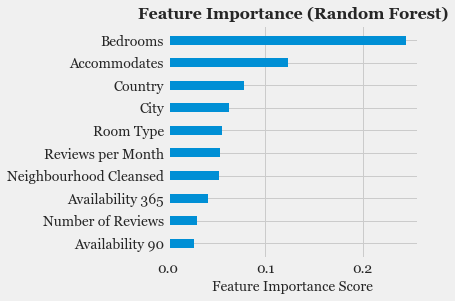

In [988]:
### Feature importance
features = df.columns
score = best_rf.feature_importances_
features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(4,4))
plt.barh(features_sorted[:10][::-1], score_sorted[:10][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (Random Forest)", fontsize=16, fontweight="bold")
plt.savefig("images_predict_price/exploratory/models/rf_featurescore.png", bbox_inches="tight")

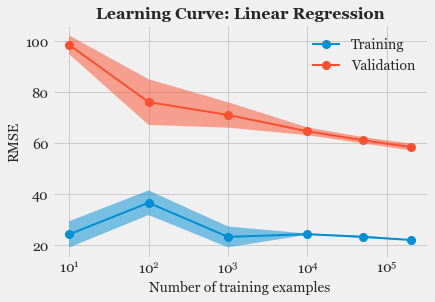

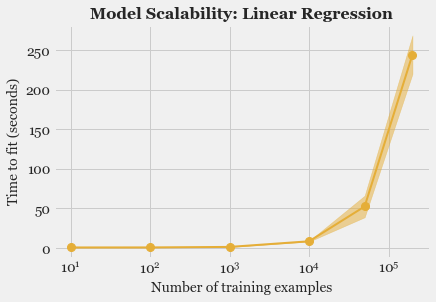

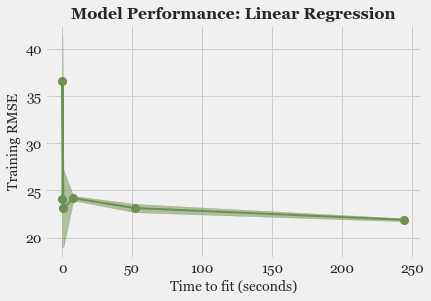

In [991]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(best_rf, "rf", [10, 100, 1000, 10000, 50000, 200000],
               [10, 100, 1000, 10000, 50000, 200000], [0, 0.8])

In [860]:
#### SVM
"""
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(df_prepared, df_labels)
df_predictions = svm_reg.predict(df_prepared)
svm_mse = mean_squared_error(df_labels, df_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse
"""
print("")

#### XGBoost

In [48]:
from sklearn import datasets, ensemble

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

default_model_xgb = ensemble.GradientBoostingRegressor(**params)
default_model_xgb.fit(df_prepared, df_labels)
#reg.fit(X_train, y_train)
#mse = mean_squared_error(y_test, reg.predict(X_test))

#default_xgb_scores = cross_val_score(default_model_xgb, df_prepared, df_labels,
#                                scoring="neg_mean_squared_error", cv=2)
#default_xgb_rmse_scores = np.sqrt(-default_xgb_scores)
#display_scores(default_xgb_rmse_scores)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

### A full pipeline with both preparation and prediction

In [ ]:
"""
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)
"""

## Model comparison using test data results

In [49]:
####################################################################
################## Final model and test RMSE #######################
def get_test_results(strat_test_set, preprocessing_pipeline, final_model):
    """
    @Params
    strat_test_set: Test data
    full_pipeline: Preprocessing pipeline
    final_model: ML Model
    
    @Returns
        test_results
    """
    test_results = {}
    #final_model = grid_search.best_estimator_

    X_test = strat_test_set.drop(["Price", "Price Label"], axis=1)
    y_test = strat_test_set["Price"].copy()

    # X_test_prepared = preprocessing_pipeline.transform(X_test)
    # final_predictions = final_model.predict(X_test_prepared)

    #"""
    ### Full pipeline with pre-processing and model
    full_pipeline = Pipeline([
            ("preparation", preprocessing_pipeline),
            ("model", final_model)
        ])
    final_predictions = full_pipeline.predict(X_test)
    #"""
    
    final_mse = mean_squared_error(y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)

    ## 95% confidence interval for the test RMSE
    confidence = 0.95
    squared_errors = (final_predictions - y_test) ** 2
    mean = squared_errors.mean()
    m = len(squared_errors)

    confidence_interval_95 = np.sqrt(stats.t.interval(confidence, m - 1,
                             loc=np.mean(squared_errors),
                             scale=stats.sem(squared_errors)))
    
    test_results["labels"] = y_test
    test_results["predictions"] = final_predictions
    test_results["squared_errors"] = squared_errors
    test_results["mse"] = final_mse
    test_results["rmse"] = final_rmse
    test_results["errors"] = np.sqrt(squared_errors)
    test_results["interval_95"] = confidence_interval_95
    
    return test_results
####################################################################

In [65]:
knn = get_test_results(strat_test_set, preprocessing_pipeline, neigh)
linreg = get_test_results(strat_test_set, preprocessing_pipeline, model_linreg)
dectree = get_test_results(strat_test_set, preprocessing_pipeline, best_dectree)
rf = get_test_results(strat_test_set, preprocessing_pipeline, best_rf)
xgb = get_test_results(strat_test_set, preprocessing_pipeline, default_model_xgb)

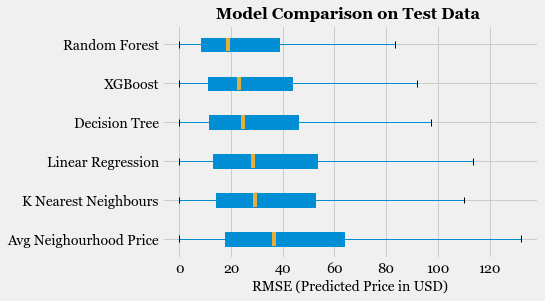

In [78]:
dft = pd.DataFrame()
dft["Avg Neighourhood Price"] = rmsescores_navg
dft["K Nearest Neighbours"] = knn["errors"]
dft["Linear Regression"] = linreg["errors"]
dft["Decision Tree"] = dectree["errors"]
dft["XGBoost"] = xgb["errors"]
dft["Random Forest"] = rf["errors"]
plt.figure(figsize=(6,4))
dft.boxplot(showfliers=False, patch_artist=True, medianprops=dict(linestyle='-', linewidth=4, color='green'),
            vert=False, widths=0.35)
ax = plt.gca()
ax.set_xlabel("RMSE (Predicted Price in USD)", fontsize=14)
ax.set_title("Model Comparison on Test Data ", fontsize=16, fontweight="bold")
plt.savefig("images_predict_price/exploratory/model_comparison.png", bbox_inches="tight")